In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from unidecode import unidecode

import sys
sys.path.append('../../')

from A_Model_Recommendation.ETL import ETL_class

In [4]:
path_titles = './../dataset/titles/'
path_rating = './../dataset/ratings/'
etl = ETL_class(path_titles, path_rating)

df_movies = etl.get_movies()
print(df_movies.shape)
df_movies.head(3)

(22998, 15)


,id,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,duration_int,duration_type,listed_in,description
0,as1,s1,movie,the grand seduction,don mckellar,"brendan gleeson, taylor kitsch, gordon pinsent",canada,2021-03-30,2014,g,113 min,113.0,min,"comedy, drama",a small fishing village must procure a local d...
1,as2,s2,movie,take care good night,girish joshi,"mahesh manjrekar, abhay mahajan, sachin khedekar",india,2021-03-30,2018,13+,110 min,110.0,min,"drama, international",a metro family decides to fight a cyber crimin...
2,as3,s3,movie,secrets of deception,josh webber,"tom sizemore, lorenzo lamas, robert lasardo, r...",united states,2021-03-30,2017,g,74 min,74.0,min,"action, drama, suspense",after a man discovers his wife is cheating on ...


In [5]:
df_movies.isna().sum()

id                   0
show_id              0
type                 0
title                0
director          8259
cast              5321
country          11499
date_added        9554
release_year         0
rating               0
duration           482
duration_int       482
duration_type      482
listed_in            0
description          4
dtype: int64

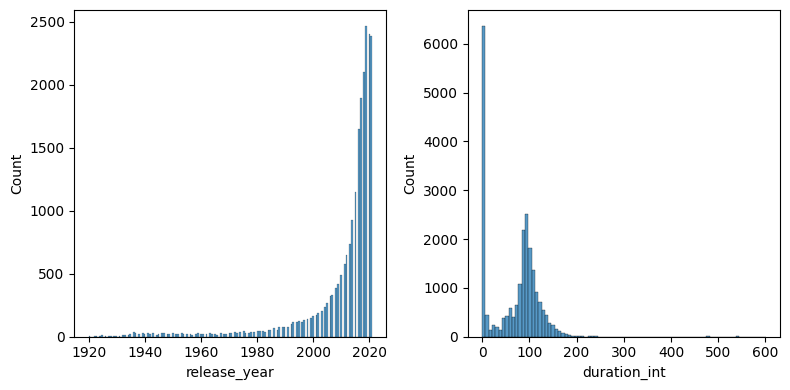

In [6]:
# sought some outliers in release_year, duration_int
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
ax = sns.histplot(df_movies['release_year'])
plt.subplot(1,2,2)
ax = sns.histplot(df_movies['duration_int'])
plt.tight_layout()
plt.show()

In [7]:
df_rating = etl.get_ratings()
print(df_rating.shape)
df_rating.head()

(11024165, 4)


,userId,rating,timestamp,movieId
0,1,1.0,1425941529,as680
1,1,4.5,1425942435,ns2186
2,1,5.0,1425941523,hs2381
3,1,5.0,1425941546,ns3663
4,1,5.0,1425941556,as9500


In [8]:
df_rating.shape

(11024165, 4)

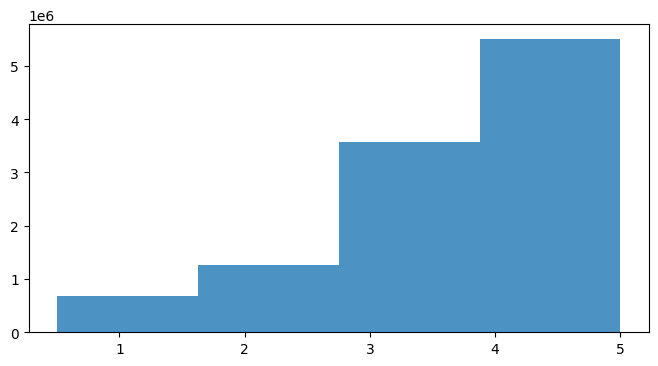

In [9]:
plt.figure(figsize=(8,4))
plt.hist(df_rating.rating.values, bins=4, alpha=0.8)
plt.show()

In [10]:
df_movies.columns

Index(['id', 'show_id', 'type', 'title', 'director', 'cast', 'country',
       'date_added', 'release_year', 'rating', 'duration', 'duration_int',
       'duration_type', 'listed_in', 'description'],
      dtype='object')

In [11]:
df_rating.columns

Index(['userId', 'rating', 'timestamp', 'movieId'], dtype='object')

In [30]:
# the longest movie in duration with optional filters (year, platform, duration_type)
last_year = np.sort(df_movies['release_year'].unique())[-1]

def get_max_duration(year=last_year, platform=None, duration_type='min'):
    if platform != None:
        platform = platform.lower()
    duration_type = duration_type.lower()
    
    df = df_movies[['id','release_year','duration_int','duration_type']]
    
    if platform == None:
        idx = df.loc[(df['duration_type'] == duration_type) & (df['release_year'] == year)]['duration_int'].idxmax()
        result = pd.DataFrame(df_movies.iloc[idx]).dropna()
        return result.T
    
    begins = platform[0]
    df = df.loc[(df['duration_type'] == duration_type) & (df['release_year'] == year)]
    df = df.loc[df['id'].str.contains('^{}'.format(begins))]
    idx = df.loc[df.duration_int == df.duration_int.max()].id.values[0]
    row = df_movies.loc[df_movies['id'] == str(idx)][['title', 'duration_int', 'duration_type']]
    column = row.columns
    result = {c: v for (c,v) in zip(column, row.values[0])}
    print("The longest movie or series in duration [{}] is '{}', it lasts {} {}".format(duration_type, row['title'].values[0],row['duration_int'].values[0],duration_type))
    
    return result

get_max_duration(year=2018, platform='amazon')

The longest movie or series in duration [min] is 'soothing surf at del norte for sleep black screen', it lasts 601.0 min


{'title': 'soothing surf at del norte for sleep black screen',
 'duration_int': 601.0,
 'duration_type': 'min'}

In [11]:
# Number of movies by platform with a score greater than P in a certain year
def get_score_count(platform, scored = 0.0, year=last_year):
    platform = platform.lower()
    
    begins = platform[0]
    df_m = df_movies[['id', 'release_year']]
    df_m = df_m.loc[df_m.release_year == year]
    df_m = df_m.loc[df_m['id'].str.contains('^{}'.format(begins))]
    
    merge = df_m.merge(df_rating[['movieId', 'rating']],left_on='id',right_on='movieId')
    merge = merge[['id', 'rating']].groupby(['id']).agg('mean')
    result = merge[merge.rating >= scored].shape[0]
    return result

year = 2006
get_score_count(platform='Amazon',scored=3.5,year=year)

110

In [18]:
# Amount of movies by platform
def get_count_platform(platform=None):
    if platform == None:
        result = df_movies[['id']].drop_duplicates()
        result = df_movies.shape[0]
        return result
    else:
        platform = platform.lower()
        begins = platform[0]
        df = df_movies.loc[df_movies['id'].str.contains('^{}'.format(begins))]
        result = df.shape[0]
        return result
get_count_platform('Amazon')

9668

In [72]:
# Most frequent actor by platform and year
def get_actor(platform: str, year: int):
    begins = platform[0]
    df = df_movies[['id','cast', 'release_year']].loc[df_movies.release_year == year]
    df = df.loc[df.id.str.contains('^{}'.format(begins))]
    
    actors = [a for x in df.cast.values for a in str(x).strip( ).split(', ')]
    actors = [unidecode(x).lower() for x in actors]
    
    values, counts = np.unique(actors, return_counts=True)
    cast = {v: int(c) for v, c in zip(values,counts)}
    
    sorted_cast = dict(sorted(cast.items(), key=lambda item: item[1], reverse=True))
    itemx = max(cast.values())
#     max_keys = {k: v for k, v in cast.items() if v == itemx}
    max_keys = {k: v for k, v in list(sorted_cast.items())[:5]}
    
    return max_keys

get_actor(platform='amazon',year=2005)

{'nan': 9,
 'bharat jadhav': 3,
 'cary-hiroyuki tagawa': 3,
 'sunil tawde': 3,
 'vijay chavan': 3}

In [ ]:
# 